# Pseudo Virtual Fields: Neural Networks act as Taylor expansions to find optimal virtual fields via weak equilibrium minimization

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from helper_FEBIO import *
from VF_helper import *
from model import *
from plot_helper import *

In [4]:
import sys
sys.path.insert(0, '../')
from core import *
#config
from config import *
#CUDA
cuda=0
device=initCUDA(cuda)
#supporting files


-----------------------------------------------------
Setting device to:  0
Test:  cuda:0
-----------------------------------------------------



/home/feolalab/anaconda3/envs/NNEUCLID/lib/python3.9/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


# Read FEBIO data

In [5]:
#Read connectivity
connectivity = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/connectivity")
connectivity

,1,1,9,133,52,24,57,153,108
0,2,9,10,134,133,57,58,154,153
1,3,10,11,135,134,58,59,155,154
2,4,11,12,136,135,59,60,156,155
3,5,12,2,25,136,60,13,73,156
4,6,52,133,129,51,108,153,157,107
...,...,...,...,...,...,...,...,...,...
119,121,117,213,104,44,56,149,45,8
120,122,213,214,103,104,149,150,46,45
121,123,214,215,102,103,150,151,47,46
122,124,215,216,101,102,151,152,48,47


In [6]:
#Read connectivity
facet_connectivity = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/facet_connectivity")
facet_connectivity

,1,1,9,57,24
0,2,52,1,24,108
1,3,52,133,9,1
2,4,9,10,58,57
3,5,133,134,10,9
4,6,10,11,59,58
...,...,...,...,...,...
144,146,101,102,47,48
145,147,151,152,48,47
146,148,88,32,7,33
147,149,32,101,48,7


### Function to read multiple states from FEBIO file

In [7]:
volume_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/volume"
volume=read_multi_ste_output2(volume_file,p=True) 

Detected 1-field blocks → ['element']
Number of states: 11
 State 1: element=125
 State 2: element=125
 State 3: element=125
 State 4: element=125
 State 5: element=125
 State 6: element=125
 State 7: element=125
 State 8: element=125
 State 9: element=125
 State 10: element=125
 State 11: element=125


In [8]:
area_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/facet_area"
area=read_multi_ste_output2(area_file,p=True) 

Detected 1-field blocks → ['element']
Number of states: 11
 State 1: element=150
 State 2: element=150
 State 3: element=150
 State 4: element=150
 State 5: element=150
 State 6: element=150
 State 7: element=150
 State 8: element=150
 State 9: element=150
 State 10: element=150
 State 11: element=150


In [9]:
stress_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/stress"
stress=read_multi_ste_output_VOIGT(stress_file,p=True)

Detected 6-field blocks → ['xx', 'yy', 'zz', 'xy', 'yz', 'xz']
Number of states: 11
 State 1: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 2: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 3: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 4: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 5: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 6: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 7: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 8: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 9: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 10: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 11: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125


In [10]:
F_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/deformation_tensor.txt"
F=read_multi_stepped_output_txt(F_file,p=True)

Step 0: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 1: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 2: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 3: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 4: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 5: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 6: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 7: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 8: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 9: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 10: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125


In [11]:
surface_normal_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/surface_normal"
surface_normal=read_multi_ste_output_VOIGT(surface_normal_file,p=True)

Detected 3-field blocks → ['x', 'y', 'z']
Number of states: 11
 State 1: x=150, y=150, z=150
 State 2: x=150, y=150, z=150
 State 3: x=150, y=150, z=150
 State 4: x=150, y=150, z=150
 State 5: x=150, y=150, z=150
 State 6: x=150, y=150, z=150
 State 7: x=150, y=150, z=150
 State 8: x=150, y=150, z=150
 State 9: x=150, y=150, z=150
 State 10: x=150, y=150, z=150
 State 11: x=150, y=150, z=150


In [12]:
position_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/position"
position=read_multi_ste_output_VOIGT(position_file,p=True)

Detected 3-field blocks → ['x', 'y', 'z']
Number of states: 11
 State 1: x=216, y=216, z=216
 State 2: x=216, y=216, z=216
 State 3: x=216, y=216, z=216
 State 4: x=216, y=216, z=216
 State 5: x=216, y=216, z=216
 State 6: x=216, y=216, z=216
 State 7: x=216, y=216, z=216
 State 8: x=216, y=216, z=216
 State 9: x=216, y=216, z=216
 State 10: x=216, y=216, z=216
 State 11: x=216, y=216, z=216


In [13]:
strain_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/output_files/lagrange_strain"
strain=read_multi_ste_output_VOIGT(strain_file,p=True)

Detected 6-field blocks → ['xx', 'yy', 'zz', 'xy', 'yz', 'xz']
Number of states: 11
 State 1: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 2: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 3: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 4: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 5: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 6: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 7: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 8: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 9: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 10: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125
 State 11: xx=125, yy=125, zz=125, xy=125, yz=125, xz=125


### Log file data

In [14]:
centroids_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/centroids.txt"
centroids_dict=read_multi_stepped_output_txt(centroids_file,p=True)

Step 0: x=125, y=125, z=125
Step 1: x=125, y=125, z=125
Step 2: x=125, y=125, z=125
Step 3: x=125, y=125, z=125
Step 4: x=125, y=125, z=125
Step 5: x=125, y=125, z=125
Step 6: x=125, y=125, z=125
Step 7: x=125, y=125, z=125
Step 8: x=125, y=125, z=125
Step 9: x=125, y=125, z=125
Step 10: x=125, y=125, z=125


In [15]:
#Centroids from log file
#centroids_file='/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/Model1.log'
#centroids_dict  = parse_states(centroids_file)

#Should get 11 states, each with exactly 1000 x/y/z values:
#print("states found:", sorted(centroids_dict.keys()))
#for step, d in centroids_dict.items():
    #print(f" step {step:2d}: x={len(d['x'])} pts, y={len(d['y'])}, z={len(d['z'])}")

### State dict to tensor

In [16]:
# 1) Build a (Nelements,3,nstates) tensor for centroids:
centroids_tensor = states_to_tensor(centroids_dict, ['x','y','z'])
print("centroids_tensor.shape:", centroids_tensor.shape)
# → (Nelements, 3, nstates)

# 2) Build a (Nelements,6,nstates) tensor for volume‐stress:
stress_tensor = states_to_tensor(stress,
                                ['xx','yy','zz','xy','xz','yz'])
print("stress_tensor.shape:", stress_tensor.shape)
# → (Nelements, 6, nstates)

# 3) If you just want the x‐only channel across states:
#x_only = states_to_tensor(centroids_dict, ['x'])
#print("x_only.shape:", x_only.shape)
# → (Nelements, 1, nstates)

# 3) Volume:
volume_tensor = states_to_tensor(volume, ['element'])
print("volume_tensor.shape:", volume_tensor.shape)
# → (Nelements, 1, nstates)

# 4) Deformation tensor:
F_tensor = states_to_tensor(F, ['Fxx','Fxy','Fxz','Fyx','Fyy','Fyz','Fzx','Fzy','Fzz'])
print("F_tensor.shape:", F_tensor.shape)

# 4) Surface Normal:
surface_normal_tensor = states_to_tensor(surface_normal, ['x','y','z'])
print("surface_normal_tensor.shape:", surface_normal_tensor.shape)


# 5) Area:
area_tensor = states_to_tensor(area, ['element'])
print("area_tensor.shape:", area_tensor.shape)


# 6) Strain:
#del strain[1]
strain_tensor = states_to_tensor(strain, ['xx','yy','zz','xy','xz','yz'])
print("strain_tensor.shape:", strain_tensor.shape)

position_tensor = states_to_tensor(position, ['x','y','z'])
print("strain_tensor.shape:", position_tensor.shape)

centroids_tensor.shape: torch.Size([125, 3, 11])
stress_tensor.shape: torch.Size([125, 6, 11])
volume_tensor.shape: torch.Size([125, 1, 11])
F_tensor.shape: torch.Size([125, 9, 11])
surface_normal_tensor.shape: torch.Size([150, 3, 11])
area_tensor.shape: torch.Size([150, 1, 11])
strain_tensor.shape: torch.Size([125, 6, 11])
strain_tensor.shape: torch.Size([216, 3, 11])


In [17]:
surface_normal_tensor[0,:,0]

tensor([ 0.0000, -1.0000, -0.0076], dtype=torch.float32)

In [18]:
position_tensor = states_to_tensor(position, ['x','y','z'])
print("strain_tensor.shape:", position_tensor.shape)

strain_tensor.shape: torch.Size([216, 3, 11])


In [19]:
torch.sum(centroids_tensor[:,:,0], dim=(0,1))

tensor(87.5000, dtype=torch.float32)

In [20]:
Nelements=F_tensor.shape[0]
Nelements

125

# Triple Branch

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class convexLinear(torch.nn.Module):
	"""

	Custom linear layer with positive weights and no bias

	Init:	size_in, size_out
	Inputs: input data
	Output: input data times softplus(trainable weight)

	"""
	def __init__(self, size_in, size_out, ):
		super().__init__()
		self.size_in, self.size_out = size_in, size_out
		weights = torch.Tensor(size_out, size_in)
		self.weights = torch.nn.Parameter(weights)

		# initialize weights
		torch.nn.init.kaiming_uniform_(self.weights, a=np.math.sqrt(5))

	def forward(self, x):
		w_times_x= torch.mm(x, torch.nn.functional.softplus(self.weights.t()))
		return w_times_x

In [129]:
class ResidualBranch(nn.Module):
    """
    A single branch with per‐layer skip connections:
      x_input --[Linear or convexLinear]--> z
       for each layer i:
          z = softplus(  branch_i(z) + skip_i(x_input)  )
    """
    def __init__(self, n_input, n_hidden, use_dropout=False, p_dropout=0.1):
        super().__init__()
        depth = len(n_hidden)
        self.layers      = nn.ModuleDict()
        self.skip_layers = nn.ModuleDict()
        self.depth       = depth
        self.use_dp      = use_dropout
        self.dp_rate     = p_dropout

        # layer 0: full input → first hidden
        self.layers["0"]      = nn.Linear(n_input, n_hidden[0])
        #self.skip_layers["0"] = nn.Identity()

        # hidden → hidden with convexLinear + softplus + skip
        for i in range(1, depth):
            self.layers[str(i)]      = convexLinear(n_hidden[i-1], n_hidden[i])
            self.skip_layers[str(i)] = nn.Linear(n_input, n_hidden[i])
        

        
    def forward(self, x):
        x0 = x                   # keep the original input for all skips
        z  = self.layers["0"](x0)
        z  = F.softplus(z)
        if self.use_dp and self.training:
            z = F.dropout(z, p=self.dp_rate)

        for i in range(1, self.depth):
            skip = self.skip_layers[str(i)](x0)
            h    = self.layers[str(i)](z)
            z    = F.softplus(h + skip)
            if self.use_dp and self.training:
                z = F.dropout(z, p=self.dp_rate)
        #y = self.layers[str(self.depth)](z) + self.skip_layers[str(self.depth)](x0)

        return z  # shape [batch, n_hidden[-1]]

In [130]:
class ICNN3D_WithResidualBranches(nn.Module):
    def __init__(self,
                 branch_input_dim: int = 3,
                 branch_hidden:    list[int] = [64,64],
                 n_coeffs:         int = 30,
                 n_fields:         int = 2,
                 use_dropout:      bool = False,
                 p_dropout:        float = 0.1):
        super().__init__()
        B0, B1 = branch_hidden
        B_last = branch_hidden[-1]
        K      = n_fields
        C      = n_coeffs

        # two residual‐skip branches
        self.branch1 = ResidualBranch(branch_input_dim, branch_hidden,
                                      use_dropout, p_dropout)
        
        self.branch2 = ResidualBranch(branch_input_dim, branch_hidden,
                                      use_dropout, p_dropout)

        # trunk: fuse 2×B_last → K·C
        fuse_dim =  B1
        self.trunk = nn.Sequential(
            convexLinear(fuse_dim, fuse_dim),
            nn.Softplus(),
            convexLinear(fuse_dim, K*C)
        )

        # K independent heads (simple linear → allow neg/pos coeffs)
        self.heads = nn.ModuleList([
            nn.Linear(C, C, bias=True)
            for _ in range(K)
        ])

        self.K = K
        self.C = C

    def forward(self, inv, cent):
        """
        inv : [Ne, 3]   → branch1
        cent: [Ne, 3]   → branch2
        returns: [Ne, K, C]
        """
        b1 = self.branch1(inv)               # [Ne, B_last]
        b2 = self.branch2(cent)              # [Ne, B_last]
        
        fuse = b1*b2 #torch.cat([b1, b2], dim=1)    # [Ne, B_last]
        flat = self.trunk(fuse)              # [Ne, K·C]

        # reshape to [Ne, K, C]
        flatK = flat.view(-1, self.K, self.C)
        outs  = []
        for k, head in enumerate(self.heads):
            vk = flatK[:, k, :]              # [Ne, C]
            outs.append(head(vk))            # [Ne, C]

        return torch.stack(outs, dim=1)      # [Ne, K, C]

In [140]:
Ne = 125
model = ICNN3D_WithResidualBranches(
    branch_input_dim=3,
    branch_hidden=[32,32],
    n_coeffs=30,
    n_fields=2,
    use_dropout=True,
    p_dropout=0.1
).float().to(device)


invariants1 = torch.randn(Ne, 3).float().to(device)
centroids1  = torch.randn(Ne, 3).float().to(device)


torch.Size([125, 2])


In [141]:

# ── 2) Create dummy inputs matching your real shapes ──────────────────
Ne = 125
dummy_inv  = torch.zeros(Ne, 3).float().to(device)  # invariants
dummy_cent = torch.zeros(Ne, 3).float().to(device)    # centroids

# ── 3) Install hooks to record shapes ─────────────────────────────────
shapes = {}
hooks = []
def hook_fn(module, inp, out):
    # record only leaf modules (no children)
    if not list(module.children()):
        shapes[module] = (inp[0].shape, out.shape)

for m in model.modules():
    hooks.append(m.register_forward_hook(hook_fn))

# ── 4) Run a single forward pass ──────────────────────────────────────
_ = model(dummy_inv, dummy_cent)

# ── 5) Remove hooks and print ─────────────────────────────────────────
for h in hooks:
    h.remove()

print(f"{'Layer':30s} | {'Input Shape':15s} → {'Output Shape'}")
print("-"* 60)
for module, (in_sh, out_sh) in shapes.items():
    print(f"{module.__class__.__name__:30s} | {str(in_sh):15s} → {out_sh}")

Layer                          | Input Shape     → Output Shape
------------------------------------------------------------
Linear                         | torch.Size([125, 3]) → torch.Size([125, 32])
Linear                         | torch.Size([125, 3]) → torch.Size([125, 32])
convexLinear                   | torch.Size([125, 32]) → torch.Size([125, 32])
Linear                         | torch.Size([125, 3]) → torch.Size([125, 32])
Linear                         | torch.Size([125, 3]) → torch.Size([125, 32])
convexLinear                   | torch.Size([125, 32]) → torch.Size([125, 32])
convexLinear                   | torch.Size([125, 32]) → torch.Size([125, 32])
Softplus                       | torch.Size([125, 32]) → torch.Size([125, 32])
convexLinear                   | torch.Size([125, 32]) → torch.Size([125, 60])
Linear                         | torch.Size([125, 30]) → torch.Size([125, 30])
Linear                         | torch.Size([125, 30]) → torch.Size([125, 30])


In [75]:
invariants=transform_to_invariants(F_tensor)
invariants.shape, centroids_tensor.shape

(torch.Size([125, 3, 11]), torch.Size([125, 3, 11]))

In [23]:
#model = ICNN3D_MultiHead(branch_hidden=[32,32], n_coeffs=30, n_fields=2).float().to(device)
#out   = model(invariants[:,:,0], centroids_tensor[:,:,0])     # → [125, 2, 30]
#print(out.shape)


## Where pressure is applied and Zero Displacement Boundary Conditions

In [42]:
pressure_nodes = parse_quad4_from_feb("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/Model1.feb", surface_name="Pressure1")
pressure_node_ids = list(pressure_nodes.keys())

In [43]:
pressure_nodes[1], type(pressure_nodes)

([5, 20, 137, 53], dict)

In [44]:
ZD_nodes = parse_quad4_from_feb("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube_Studio3/jobs/Model1.feb", surface_name="ZeroDisplacement1")
ZD_node_ids = list(ZD_nodes.keys())
ZD_idx = torch.tensor([nid - 1 for nid in ZD_node_ids], dtype=torch.long)
ZD_idx[:10], ZD_node_ids[:10]

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [45]:
ZD_nodes[1], len(ZD_node_ids)

([4, 40, 121, 49], 25)

In [46]:
connectivity_list = [
    tuple(map(int, row))           # ensure ints
    for row in connectivity.values
]

In [47]:
# 2) Flatten pressure-node dict into a set of node IDs
pressure_nodes_set = {
    n
    for nodes in pressure_nodes.values()
    for n in nodes
}

mapping_element_pressure = map_pressure_to_elements(connectivity_list, pressure_nodes_set)
#print(mapping.keys())
# (3) inspect
for eid, info in mapping_element_pressure.items():
    print(f"Element {eid}:")
    print("  all_nodes:     ", info['all_nodes'])
    print("  pressure_nodes:", info['pressure_nodes'])

Element 101:
  all_nodes:      [21, 69, 201, 120, 5, 20, 137, 53]
  pressure_nodes: [5, 20, 137, 53]
Element 102:
  all_nodes:      [69, 70, 202, 201, 20, 19, 138, 137]
  pressure_nodes: [20, 19, 138, 137]
Element 103:
  all_nodes:      [70, 71, 203, 202, 19, 18, 139, 138]
  pressure_nodes: [19, 18, 139, 138]
Element 104:
  all_nodes:      [71, 72, 204, 203, 18, 17, 140, 139]
  pressure_nodes: [18, 17, 140, 139]
Element 105:
  all_nodes:      [72, 16, 85, 204, 17, 6, 36, 140]
  pressure_nodes: [17, 6, 36, 140]
Element 106:
  all_nodes:      [120, 201, 205, 119, 53, 137, 141, 54]
  pressure_nodes: [53, 137, 141, 54]
Element 107:
  all_nodes:      [201, 202, 206, 205, 137, 138, 142, 141]
  pressure_nodes: [137, 138, 142, 141]
Element 108:
  all_nodes:      [202, 203, 207, 206, 138, 139, 143, 142]
  pressure_nodes: [138, 139, 143, 142]
Element 109:
  all_nodes:      [203, 204, 208, 207, 139, 140, 144, 143]
  pressure_nodes: [139, 140, 144, 143]
Element 110:
  all_nodes:      [204, 85, 86,

In [48]:
# 2) Flatten pressure-node dict into a set of node IDs
ZD_nodes_set = {
    n
    for nodes in ZD_nodes.values()
    for n in nodes
}

mapping_element_ZD = map_pressure_to_elements(connectivity_list, ZD_nodes_set)
#print(mapping.keys())
# (3) inspect
for eid, info in mapping_element_ZD.items():
    print(f"Element {eid}:")
    print("  all_nodes:     ", info['all_nodes'])
    print("  pressure_nodes:", info['pressure_nodes'])

Element 2:
  all_nodes:      [9, 10, 134, 133, 57, 58, 154, 153]
  pressure_nodes: [9, 10, 134, 133]
Element 3:
  all_nodes:      [10, 11, 135, 134, 58, 59, 155, 154]
  pressure_nodes: [10, 11, 135, 134]
Element 4:
  all_nodes:      [11, 12, 136, 135, 59, 60, 156, 155]
  pressure_nodes: [11, 12, 136, 135]
Element 5:
  all_nodes:      [12, 2, 25, 136, 60, 13, 73, 156]
  pressure_nodes: [12, 2, 25, 136]
Element 6:
  all_nodes:      [52, 133, 129, 51, 108, 153, 157, 107]
  pressure_nodes: [52, 133, 129, 51]
Element 7:
  all_nodes:      [133, 134, 130, 129, 153, 154, 158, 157]
  pressure_nodes: [133, 134, 130, 129]
Element 8:
  all_nodes:      [134, 135, 131, 130, 154, 155, 159, 158]
  pressure_nodes: [134, 135, 131, 130]
Element 9:
  all_nodes:      [135, 136, 132, 131, 155, 156, 160, 159]
  pressure_nodes: [135, 136, 132, 131]
Element 10:
  all_nodes:      [136, 25, 26, 132, 156, 73, 74, 160]
  pressure_nodes: [136, 25, 26, 132]
Element 11:
  all_nodes:      [51, 129, 125, 50, 107, 157, 

In [49]:
pressure_element_IDs=list(mapping_element_pressure.keys())

pressure_element_IDs_final = torch.tensor([nid - 1 for nid in pressure_element_IDs], dtype=torch.long)

#len(pressure_element_IDs_final)

In [50]:
ZD_element_IDs=list(mapping_element_ZD.keys())

ZD_element_IDs_final = torch.tensor([nid - 1 for nid in ZD_element_IDs], dtype=torch.long)

#len(pressure_element_IDs_final)

In [51]:
ZD_element_IDs_final

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24])

In [52]:
#Get normals of surfaces where pressure is applied
# 1) zero‐based indices for those nodes:
idx = torch.tensor([nid - 1 for nid in pressure_node_ids], dtype=torch.long)
idx_ZD = torch.tensor([nid - 1 for nid in ZD_node_ids], dtype=torch.long)

# 2) index into the first dimension:
#    result has shape (100, 3, 11)
pressure_normals = surface_normal_tensor[idx, :, :]
area_normals = area_tensor[idx, :, :]

#ZD:
ZD_normals = surface_normal_tensor[idx_ZD, :, :]
ZD_areas = area_tensor[idx_ZD, :, :]


print(pressure_normals.shape)  # → torch.Size([100, 3, 11])
print(ZD_normals.shape)  # → torch.Size([100, 3, 11])

torch.Size([25, 3, 11])
torch.Size([25, 3, 11])


In [53]:
#print("VF.shape =", VF.shape)
print("max idx =", max(pressure_element_IDs_final).item())
print("min idx =", min(pressure_element_IDs_final).item())


max idx = 124
min idx = 100


# Surface Normals

In [54]:
surface_normal_tensor.shape

torch.Size([150, 3, 11])

In [55]:
facet_connectivity_list = [
    tuple(map(int, row))           # ensure ints
    for row in facet_connectivity.values
]

In [56]:
facet_connectivity_list

[(2, 52, 1, 24, 108),
 (3, 52, 133, 9, 1),
 (4, 9, 10, 58, 57),
 (5, 133, 134, 10, 9),
 (6, 10, 11, 59, 58),
 (7, 134, 135, 11, 10),
 (8, 11, 12, 60, 59),
 (9, 135, 136, 12, 11),
 (10, 12, 2, 13, 60),
 (11, 2, 25, 73, 13),
 (12, 136, 25, 2, 12),
 (13, 51, 52, 108, 107),
 (14, 51, 129, 133, 52),
 (15, 129, 130, 134, 133),
 (16, 130, 131, 135, 134),
 (17, 131, 132, 136, 135),
 (18, 25, 26, 74, 73),
 (19, 132, 26, 25, 136),
 (20, 50, 51, 107, 106),
 (21, 50, 125, 129, 51),
 (22, 125, 126, 130, 129),
 (23, 126, 127, 131, 130),
 (24, 127, 128, 132, 131),
 (25, 26, 27, 75, 74),
 (26, 128, 27, 26, 132),
 (27, 49, 50, 106, 105),
 (28, 49, 121, 125, 50),
 (29, 121, 122, 126, 125),
 (30, 122, 123, 127, 126),
 (31, 123, 124, 128, 127),
 (32, 27, 28, 76, 75),
 (33, 124, 28, 27, 128),
 (34, 40, 4, 41, 92),
 (35, 4, 49, 105, 41),
 (36, 4, 40, 121, 49),
 (37, 39, 40, 92, 91),
 (38, 40, 39, 122, 121),
 (39, 38, 39, 91, 90),
 (40, 39, 38, 123, 122),
 (41, 37, 38, 90, 89),
 (42, 38, 37, 124, 123),
 (43,

In [57]:
facet2elems = map_facets_to_elements(connectivity_list, facet_connectivity_list)
for fid, info in facet2elems.items():
    print(f"Facet {fid} with nodes {info['facet_nodes']} → elements {info['element_ids']}")

Facet 4 with nodes [9, 10, 58, 57] → elements [2]
Facet 5 with nodes [133, 134, 10, 9] → elements [2]
Facet 6 with nodes [10, 11, 59, 58] → elements [3]
Facet 7 with nodes [134, 135, 11, 10] → elements [3]
Facet 8 with nodes [11, 12, 60, 59] → elements [4]
Facet 9 with nodes [135, 136, 12, 11] → elements [4]
Facet 10 with nodes [12, 2, 13, 60] → elements [5]
Facet 11 with nodes [2, 25, 73, 13] → elements [5]
Facet 12 with nodes [136, 25, 2, 12] → elements [5]
Facet 13 with nodes [51, 52, 108, 107] → elements [6]
Facet 14 with nodes [51, 129, 133, 52] → elements [6]
Facet 15 with nodes [129, 130, 134, 133] → elements [7]
Facet 16 with nodes [130, 131, 135, 134] → elements [8]
Facet 17 with nodes [131, 132, 136, 135] → elements [9]
Facet 18 with nodes [25, 26, 74, 73] → elements [10]
Facet 19 with nodes [132, 26, 25, 136] → elements [10]
Facet 20 with nodes [50, 51, 107, 106] → elements [11]
Facet 21 with nodes [50, 125, 129, 51] → elements [11]
Facet 22 with nodes [125, 126, 130, 129] →

In [58]:
element2facets = {}
for facet_id, info in facet2elems.items():
    for eid in info['element_ids']:
        element2facets.setdefault(eid, []).append(facet_id) 
element2facets

{2: [4, 5],
 3: [6, 7],
 4: [8, 9],
 5: [10, 11, 12],
 6: [13, 14],
 7: [15],
 8: [16],
 9: [17],
 10: [18, 19],
 11: [20, 21],
 12: [22],
 13: [23],
 14: [24],
 15: [25, 26],
 16: [27, 28],
 17: [29],
 18: [30],
 19: [31],
 20: [32, 33],
 21: [34, 35, 36],
 22: [37, 38],
 23: [39, 40],
 24: [41, 42],
 25: [43, 44, 45],
 26: [46, 47],
 27: [48],
 28: [49],
 29: [50],
 30: [51, 52],
 31: [53],
 35: [54],
 36: [55],
 40: [56],
 41: [57],
 45: [58],
 46: [59, 60],
 47: [61],
 48: [62],
 49: [63],
 50: [64, 65],
 51: [66, 67],
 52: [68],
 53: [69],
 54: [70],
 55: [71, 72],
 56: [73],
 60: [74],
 61: [75],
 65: [76],
 66: [77],
 70: [78],
 71: [79, 80],
 72: [81],
 73: [82],
 74: [83],
 75: [84, 85],
 76: [86, 87],
 77: [88],
 78: [89],
 79: [90],
 80: [91, 92],
 81: [93],
 85: [94],
 86: [95],
 90: [96],
 91: [97],
 95: [98],
 96: [99, 100],
 97: [101],
 98: [102],
 99: [103],
 100: [104, 105],
 101: [106, 107, 108],
 102: [109, 110],
 103: [111, 112],
 104: [113, 114],
 105: [115, 116, 1

In [59]:
eid, idx

(125,
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24]))

In [60]:
# 1) select only the pressured elements
pressure_elements_facets = {
    eid-1: element2facets[eid] #minus one to account for python indexing
    for eid in pressure_element_IDs
    if eid in element2facets
}

In [61]:
for eid, info in mapping_element_pressure.items():
    pset = set(info['pressure_nodes'])
    # find the facet(s) whose node-set exactly matches the pressure nodes
    facet_ids = [
        fid
        for fid, n1, n2, n3, n4 in facet_connectivity_list
        if set((n1, n2, n3, n4)) == pset
    ]
    info['facet_ids'] = facet_ids

# inspect
for eid, info in mapping_element_pressure.items():
    print(f"Element {eid}:")
    print("  all_nodes:      ", info['all_nodes'])
    print("  pressure_nodes: ", info['pressure_nodes'])
    print("  facet_ids:      ", info.get('facet_ids', []))

Element 101:
  all_nodes:       [21, 69, 201, 120, 5, 20, 137, 53]
  pressure_nodes:  [5, 20, 137, 53]
  facet_ids:       [108]
Element 102:
  all_nodes:       [69, 70, 202, 201, 20, 19, 138, 137]
  pressure_nodes:  [20, 19, 138, 137]
  facet_ids:       [110]
Element 103:
  all_nodes:       [70, 71, 203, 202, 19, 18, 139, 138]
  pressure_nodes:  [19, 18, 139, 138]
  facet_ids:       [112]
Element 104:
  all_nodes:       [71, 72, 204, 203, 18, 17, 140, 139]
  pressure_nodes:  [18, 17, 140, 139]
  facet_ids:       [114]
Element 105:
  all_nodes:       [72, 16, 85, 204, 17, 6, 36, 140]
  pressure_nodes:  [17, 6, 36, 140]
  facet_ids:       [117]
Element 106:
  all_nodes:       [120, 201, 205, 119, 53, 137, 141, 54]
  pressure_nodes:  [53, 137, 141, 54]
  facet_ids:       [119]
Element 107:
  all_nodes:       [201, 202, 206, 205, 137, 138, 142, 141]
  pressure_nodes:  [137, 138, 142, 141]
  facet_ids:       [120]
Element 108:
  all_nodes:       [202, 203, 207, 206, 138, 139, 143, 142]
  pr

In [62]:
for eid, info in mapping_element_ZD.items():
    pset = set(info['pressure_nodes'])
    # find the facet(s) whose node-set exactly matches the pressure nodes
    facet_ids = [
        fid
        for fid, n1, n2, n3, n4 in facet_connectivity_list
        if set((n1, n2, n3, n4)) == pset
    ]
    info['facet_ids'] = facet_ids

# inspect
for eid, info in mapping_element_ZD.items():
    print(f"Element {eid}:")
    print("  all_nodes:      ", info['all_nodes'])
    print("  pressure_nodes: ", info['pressure_nodes'])
    print("  facet_ids:      ", info.get('facet_ids', []))

Element 2:
  all_nodes:       [9, 10, 134, 133, 57, 58, 154, 153]
  pressure_nodes:  [9, 10, 134, 133]
  facet_ids:       [5]
Element 3:
  all_nodes:       [10, 11, 135, 134, 58, 59, 155, 154]
  pressure_nodes:  [10, 11, 135, 134]
  facet_ids:       [7]
Element 4:
  all_nodes:       [11, 12, 136, 135, 59, 60, 156, 155]
  pressure_nodes:  [11, 12, 136, 135]
  facet_ids:       [9]
Element 5:
  all_nodes:       [12, 2, 25, 136, 60, 13, 73, 156]
  pressure_nodes:  [12, 2, 25, 136]
  facet_ids:       [12]
Element 6:
  all_nodes:       [52, 133, 129, 51, 108, 153, 157, 107]
  pressure_nodes:  [52, 133, 129, 51]
  facet_ids:       [14]
Element 7:
  all_nodes:       [133, 134, 130, 129, 153, 154, 158, 157]
  pressure_nodes:  [133, 134, 130, 129]
  facet_ids:       [15]
Element 8:
  all_nodes:       [134, 135, 131, 130, 154, 155, 159, 158]
  pressure_nodes:  [134, 135, 131, 130]
  facet_ids:       [16]
Element 9:
  all_nodes:       [135, 136, 132, 131, 155, 156, 160, 159]
  pressure_nodes:  [13

In [63]:
pressure_elem_facets_indexes = [
    (eid-1, fid-1)
    for eid, info in mapping_element_pressure.items()
    for fid in info.get('facet_ids', [])
]
pressure_elem_facets_indexes[0]

(100, 107)

In [64]:
ZD_elem_facets_indexes = [
    (eid-1, fid-1)
    for eid, info in mapping_element_ZD.items()
    for fid in info.get('facet_ids', [])
]
ZD_elem_facets_indexes[0]

(1, 4)

In [65]:
# 1) Extract index lists
elem_idxs  = torch.tensor([e for e, f in pressure_elem_facets_indexes], dtype=torch.long)
facet_idxs = torch.tensor([f for e, f in pressure_elem_facets_indexes], dtype=torch.long)

In [66]:
# 1) Extract index lists
ZD_elem_idxs  = torch.tensor([e for e, f in ZD_elem_facets_indexes], dtype=torch.long)
ZD_facet_idxs = torch.tensor([f for e, f in ZD_elem_facets_indexes], dtype=torch.long)

In [67]:
elem_idxs, ZD_elem_idxs

(tensor([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
         114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24]))

In [68]:
facet_idxs

tensor([107, 109, 111, 113, 116, 118, 119, 120, 121, 123, 125, 126, 127, 128,
        130, 132, 133, 134, 135, 137, 140, 142, 144, 146, 149])

# Architecture

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
#del model

In [50]:
from model import *

vf_number=2 #linear elastic is 2 parameters
model = Taylor_with_heads(n_input=3,
                n_hidden=[128,128,128],
                n_output=30,
                use_dropout=True,
                dropout_rate=0.2,
                centroids=False, p_fields=vf_number)

from model import *

vf_number=2 #linear elastic is 2 parameters
model = ICNN3D_Taylor_multifield_with_neg(n_input=3,
                n_hidden=[128,128,128],
                n_output=30,
                use_dropout=True,
                dropout_rate=0.2,
                centroids=True, p_fields=vf_number)

In [138]:
from torchinfo import summary
model = model.to(device)
summary(model)

Layer (type:depth-idx)                   Param #
ICNN3D_WithResidualBranches              --
├─ResidualBranch: 1-1                    --
│    └─ModuleDict: 2-1                   --
│    │    └─Linear: 3-1                  256
│    │    └─convexLinear: 3-2            4,096
│    │    └─convexLinear: 3-3            64
│    └─ModuleDict: 2-2                   --
│    │    └─Linear: 3-4                  256
│    │    └─convexLinear: 3-5            3
├─ResidualBranch: 1-2                    --
│    └─ModuleDict: 2-3                   --
│    │    └─Linear: 3-6                  256
│    │    └─convexLinear: 3-7            4,096
│    │    └─convexLinear: 3-8            64
│    └─ModuleDict: 2-4                   --
│    │    └─Linear: 3-9                  256
│    │    └─convexLinear: 3-10           3
├─Sequential: 1-3                        --
│    └─convexLinear: 2-5                 4,096
│    └─Softplus: 2-6                     --
│    └─convexLinear: 2-7                 3,840
├─ModuleList:

## Training loop

In [95]:
F_tensor.shape, stress_tensor.shape, centroids_tensor.shape

(torch.Size([125, 9, 11]), torch.Size([125, 6, 11]), torch.Size([125, 3, 11]))

In [96]:
x_input= torch.cat(( F_tensor.to(device),centroids_tensor.to(device)), dim=1)
x_input= F_tensor.to(device)
x_input.shape

torch.Size([125, 9, 11])

In [71]:
stress_tensor_3d=Voigt_to_3d_v2(stress_tensor)
strain_tensor_3d=Voigt_to_3d_v2(strain_tensor)

V2
V2


In [142]:
model.apply(init_weights)

ICNN3D_WithResidualBranches(
  (branch1): ResidualBranch(
    (layers): ModuleDict(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): convexLinear()
    )
    (skip_layers): ModuleDict(
      (1): Linear(in_features=3, out_features=32, bias=True)
    )
  )
  (branch2): ResidualBranch(
    (layers): ModuleDict(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): convexLinear()
    )
    (skip_layers): ModuleDict(
      (1): Linear(in_features=3, out_features=32, bias=True)
    )
  )
  (trunk): Sequential(
    (0): convexLinear()
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): convexLinear()
  )
  (heads): ModuleList(
    (0-1): 2 x Linear(in_features=30, out_features=30, bias=True)
  )
)

#### Train
If we keep the strain pointwise throughout the solid we can get a map of parameters...

In [143]:
#PER ELEMENT....
epoch=500
# Adam with a learning rate:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

#Number of states:

states=F_tensor.shape[2]
N_pressure_dofs=len(pressure_element_IDs_final)
N_ZD_dofs=len(ZD_element_IDs_final)
loss_list=[]
keys = ['Internal', 'External', 'ZD','Special']
work_dict = { key: [] for key in keys }
P_max  = 100000.0            # negative = compression
# make a “linear ramp” of 11 pressures from 0 → P_max
pressure_curve = torch.linspace(0.0, P_max, steps=states, device=device)

### Triple branch

In [144]:
for i in range(epoch):
    
    optimizer.zero_grad()#reset gradients

    loss = torch.zeros((), device=device)    # scalar, same dtype/device
    #Estimate
    for s in range(1,states):
        V_NN   = model(invariants[:,:,s], centroids_tensor[:,:,s])     # → [125, 2, 30]
        #print(f'V_NN shape: {V_NN.shape}')
        
        delta_xyz= calculate_point(centroids_tensor, s) #This is N,3
        #print(f'delta_xyz shape: {delta_xyz.shape}')

        VF_values = evaluate_vf_values_per_element(V_NN, delta_xyz) #This is [125, 2, 3]
        #print(f'VF_values shape: {VF_values.shape}')

        grad_VF= construct_vf_gradients_per_element(V_NN, delta_xyz) #This is [125, 2, 3, 3] 
        #print(f'grad_VF shape: {grad_VF.shape}')

        #Strain
        virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3))
        #print(f'virtual_strain shape: {virtual_strain.shape}')

        #Volume integral:
        # element‐wise inner product σ^e : ∇v^e
        integrand = torch.sum(stress_tensor_3d[:,:,:,s].unsqueeze(1) * virtual_strain, dim=(2, 3)) # → shape [p,N]
        #print(f'Integrand shape: {integrand.shape}')
    
        W_int = torch.sum(integrand * volume_tensor[:,:,s] ,dim=(0,1)) #/(Nelements*vf_number) 
        #print(f'W_int shape: {W_int.shape}')

        #Surface integral
        #Adding negative to the pressure becuase it is applied downwards...
        t_surface=-surface_normal_tensor[facet_idxs,:,s]*(pressure_curve[s]) #*area_tensor[facet_idxs,:,s] #t_surface is N_pressure,3 (elements x xyz), add area because pressure is not force
        #print(f't_surface shape: {t_surface.shape}')
   
        dot = (VF_values[elem_idxs,:,:]* t_surface.unsqueeze(1)).sum(dim=2)  # shape: [3, 100]
        #print(f'dot shape: {dot.shape}')

        W_ext=torch.sum(dot*area_tensor[facet_idxs,:,s],dim=(0,1)) #/(N_pressure_dofs*vf_number)
        #print(f'W_ext shape: {W_ext.shape}')

        loss+=((W_int-W_ext)**2)*1e-10
        
    loss/=states
    loss_list.append(loss.item())
    work_dict['Internal'].append(W_int.item())
    work_dict['External'].append(W_ext.item())

    if i % 50 == 0:
        W_int_item = W_int.item()
        W_ext_item = W_ext.item()
        L_item    = loss.item()
        print(f"Epoch {i:4d} │ "
            f"W_int (internal work): {W_int_item: .2e} │ "
            f"W_ext (external work): {W_ext_item: .2e} │ "
            f"Loss: {L_item: .2e}")

    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()



Epoch    0 │ W_int (internal work): -2.75e+10 │ W_ext (external work): -1.22e+11 │ Loss:  3.06e+11
Epoch   50 │ W_int (internal work): -7.48e+09 │ W_ext (external work): -7.28e+09 │ Loss:  3.07e+06
Epoch  100 │ W_int (internal work):  1.86e+07 │ W_ext (external work): -9.59e+07 │ Loss:  4.57e+05
Epoch  150 │ W_int (internal work): -7.68e+06 │ W_ext (external work): -3.92e+06 │ Loss:  5.15e+02
Epoch  200 │ W_int (internal work):  2.62e+06 │ W_ext (external work):  6.47e+05 │ Loss:  1.44e+02
Epoch  250 │ W_int (internal work): -1.79e+05 │ W_ext (external work):  5.61e+05 │ Loss:  1.86e+01
Epoch  300 │ W_int (internal work): -2.62e+05 │ W_ext (external work):  3.61e+05 │ Loss:  1.30e+01
Epoch  350 │ W_int (internal work):  1.37e+05 │ W_ext (external work): -3.85e+05 │ Loss:  9.60e+00
Epoch  400 │ W_int (internal work): -4.59e+05 │ W_ext (external work):  2.55e+05 │ Loss:  1.76e+01
Epoch  450 │ W_int (internal work): -4.24e+05 │ W_ext (external work):  1.45e+05 │ Loss:  1.13e+01


In [103]:
# after loss.backward()
for name, p in model.named_parameters():
    if p.grad is None:
        print(f"{name:30s} has no grad")
    else:
        g = p.grad.data.norm().item()
        if g==0.0:
            print(f"{name:30s} grad ZERO")
        else:
            print(f"{name:30s} grad {g:.2e}")


branch1.layers.0.weight        grad 7.73e-11
branch1.layers.0.bias          grad 5.55e-09
branch1.layers.1.weights       grad 2.17e-10
branch1.layers.2.weights       has no grad
branch1.skip_layers.1.weight   grad 2.20e-12
branch1.skip_layers.1.bias     grad 1.58e-10
branch1.skip_layers.2.weights  has no grad
branch2.layers.0.weight        grad 4.18e-09
branch2.layers.0.bias          grad 5.58e-09
branch2.layers.1.weights       grad 5.04e-10
branch2.layers.2.weights       has no grad
branch2.skip_layers.1.weight   grad 1.20e-10
branch2.skip_layers.1.bias     grad 1.59e-10
branch2.skip_layers.2.weights  has no grad
trunk.0.weights                grad 1.48e-11
trunk.2.weights                grad 2.86e-02
heads.0.weight                 grad 7.19e-01
heads.0.bias                   grad 4.63e-03
heads.1.weight                 grad 6.94e-01
heads.1.bias                   grad 4.63e-03


In [105]:
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if p.grad is None:
        print(f"{name:30s} | grad is None")
    else:
        print(f"{name:30s} | grad norm = {p.grad.norm().item():.2e}")


branch1.layers.0.weight        | grad norm = 7.73e-11
branch1.layers.0.bias          | grad norm = 5.55e-09
branch1.layers.1.weights       | grad norm = 2.17e-10
branch1.layers.2.weights       | grad is None
branch1.skip_layers.1.weight   | grad norm = 2.20e-12
branch1.skip_layers.1.bias     | grad norm = 1.58e-10
branch1.skip_layers.2.weights  | grad is None
branch2.layers.0.weight        | grad norm = 4.18e-09
branch2.layers.0.bias          | grad norm = 5.58e-09
branch2.layers.1.weights       | grad norm = 5.04e-10
branch2.layers.2.weights       | grad is None
branch2.skip_layers.1.weight   | grad norm = 1.20e-10
branch2.skip_layers.1.bias     | grad norm = 1.59e-10
branch2.skip_layers.2.weights  | grad is None
trunk.0.weights                | grad norm = 1.48e-11
trunk.2.weights                | grad norm = 2.86e-02
heads.0.weight                 | grad norm = 7.19e-01
heads.0.bias                   | grad norm = 4.63e-03
heads.1.weight                 | grad norm = 6.94e-01
heads.

In [106]:
print_vf_equations(V_NN[:,0,:].mean(dim=0), fmt="{:+.3f}")

Vx(x,y,z) = -43.925*1 + +26.100*x + -22.722*y + -44.607*z + +38.609*x**2 + +62.025*x*y + -47.112*x*z + +13.485*y**2 + +23.662*y*z + -1.452*z**2
Vy(x,y,z) = -9.182*1 + +61.109*x + -80.828*y + +83.875*z + -52.027*x**2 + -9.157*x*y + +128.540*x*z + -45.733*y**2 + +41.243*y*z + +12.651*z**2
Vz(x,y,z) = -44.672*1 + -19.085*x + -17.819*y + +40.768*z + +64.958*x**2 + -42.549*x*y + -55.780*x*z + +19.247*y**2 + -16.363*y*z + -59.370*z**2


In [107]:
print_vf_equations(V_NN[:,1,:].mean(dim=0), fmt="{:+.3f}")

Vx(x,y,z) = +3.808*1 + +50.808*x + -28.369*y + +13.109*z + +82.539*x**2 + +11.439*x*y + +42.528*x*z + -10.755*y**2 + +5.965*y*z + -10.061*z**2
Vy(x,y,z) = -33.166*1 + -42.747*x + +7.495*y + +52.666*z + +94.517*x**2 + +1.738*x*y + +33.979*x*z + -25.949*y**2 + +9.170*y*z + -13.161*z**2
Vz(x,y,z) = +6.753*1 + -21.892*x + -22.513*y + +4.790*z + -31.826*x**2 + +49.347*x*y + +16.915*x*z + -23.798*y**2 + +39.685*y*z + +20.426*z**2


## VF heads

In [57]:
for i in range(epoch):
    optimizer.zero_grad()#reset gradients
    loss = torch.zeros((), device=device)    # scalar, same dtype/device
    #Estimate
    for s in range(1,states):
        V_NN=model(x_input[:,:,s]) #This is [125, 2, 30]
        #print(f'V_NN shape: {V_NN.shape}')

        delta_xyz=calculate_point(centroids_tensor, s) #This is N,3
        #print(f'delta_xyz shape: {delta_xyz.shape}')

        VF_values = evaluate_vf_values_per_element(V_NN, delta_xyz) #This is [125, 2, 3]
        #print(f'VF_values shape: {VF_values.shape}')


        grad_VF= construct_vf_gradients_per_element(V_NN, delta_xyz) #This is [125, 2, 3, 3] 
        #print(f'grad_VF shape: {grad_VF.shape}')


        #Strain
        virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3))
        #print(f'virtual_strain shape: {virtual_strain.shape}')


        #Volume integral:
        # element‐wise inner product σ^e : ∇v^e
        integrand = torch.sum(stress_tensor_3d[:,:,:,s].unsqueeze(1) * virtual_strain, dim=(2, 3)) # → shape [p,N]
        #print(f'Integrand shape: {integrand.shape}')
    
        W_int = torch.sum(integrand * volume_tensor[:,:,s] ,dim=(0,1)) #/(Nelements*vf_number) 
        #print(f'W_int shape: {W_int.shape}')

        #Surface integral
        #Adding negative to the pressure becuase it is applied downwards...
        t_surface=-surface_normal_tensor[facet_idxs,:,s]*(pressure_curve[s]) #*area_tensor[facet_idxs,:,s] #t_surface is N_pressure,3 (elements x xyz), add area because pressure is not force
        #print(f't_surface shape: {t_surface.shape}')
   
        dot = (VF_values[elem_idxs,:,:]* t_surface.unsqueeze(1)).sum(dim=2)  # shape: [3, 100]
        #print(f'dot shape: {dot.shape}')

        W_ext=torch.sum(dot*area_tensor[facet_idxs,:,s],dim=(0,1)) #/(N_pressure_dofs*vf_number)
        #print(f'W_ext shape: {W_ext.shape}')

        loss+=((W_int-W_ext)**2)
        
    #loss/=states
    loss_list.append(loss.item())
    work_dict['Internal'].append(W_int.item())
    work_dict['External'].append(W_ext.item())

    if i % 50 == 0:
        W_int_item = W_int.item()
        W_ext_item = W_ext.item()
        L_item    = loss.item()
        print(f"Epoch {i:4d} │ "
            f"W_int (internal work): {W_int_item: .2e} │ "
            f"W_ext (external work): {W_ext_item: .2e} │ "
            f"Loss: {L_item: .2e}")

    loss.backward()

    optimizer.step()



Epoch    0 │ W_int (internal work): -4.86e+03 │ W_ext (external work): -6.91e+03 │ Loss:  1.54e+07


In [58]:
V_NN.shape

torch.Size([125, 2, 30])

## Train ORIG

In [236]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.norm().item())


branch1.0.weights 9343270.0
branch1.2.weights 179741440.0
branch2.0.weights 83003664.0
branch2.2.weights 150401280.0
trunk.0.weights 489544096.0
trunk.2.weights 1223596160.0
heads.0.0.weights 3230477056.0
heads.0.1.weight 4377327104.0
heads.0.1.bias 110864880.0
heads.1.0.weights 2595565568.0
heads.1.1.weight 4098146048.0
heads.1.1.bias 110864880.0


In [60]:
M = A.mean(dim=2)
M, A_norm.mean(dim=2)

NameError: name 'A' is not defined

In [246]:
A = torch.stack([A1, A2], dim=1)       # → [2, n_vf, Ne]
M = A.mean(dim=2)      
#M2= M / M.sum(dim=0, keepdim=True)                # → [2, n_vf]

I = torch.eye(2, device=A.device).unsqueeze(2)  #2,2,1

frobenius_per_matrix = (A-I ** 2).sum(dim=(0,1))  # [125]
special_loss = frobenius_per_matrix.mean()

special_loss1 = ((M / (M.sum(dim=0, keepdim=True) + 1e-8) #Norm 
                  - torch.eye(vf_number, device=M.device, dtype=M.dtype))**2).sum()
special_loss, special_loss1

(tensor(-1.9999, grad_fn=<MeanBackward0>),
 tensor(3.8750, dtype=torch.float32, grad_fn=<SumBackward0>))

In [77]:
A = torch.stack([A1, A2], dim=1)       # → [2, n_vf, Ne]
#M = A.mean(dim=2)      
#M2= M / M.sum(dim=0, keepdim=True)                # → [2, n_vf]

I = torch.eye(2, device=A.device).unsqueeze(2)  

A.shape, I.shape, (A-I).shape

(torch.Size([2, 2, 125]), torch.Size([2, 2, 1]), torch.Size([2, 2, 125]))

In [58]:
M /M.sum(dim=0, keepdim=True) 

tensor([[ 1.0052,  0.1668],
        [-0.0052,  0.8332]], dtype=torch.float32, grad_fn=<DivBackward0>)

In [132]:
print_vf_equations(V_NN[0], fmt="{:+.3f}")

ValueError: Expected 30 coefficients, got 60

In [248]:
print_vf_equations(V_NN[1], fmt="{:+.3f}")

Vx(x,y,z) = +0.062*1 + +0.074*x + +0.031*y + -0.049*z + -0.050*x**2 + +0.031*x*y + +0.066*x*z + -0.118*y**2 + -0.068*y*z + +0.112*z**2
Vy(x,y,z) = +0.044*1 + +0.117*x + +0.159*y + -0.038*z + -0.097*x**2 + +0.069*x*y + +0.066*x*z + -0.143*y**2 + +0.136*y*z + -0.106*z**2
Vz(x,y,z) = -0.018*1 + -0.006*x + -0.119*y + -0.103*z + +0.127*x**2 + +0.149*x*y + +0.075*x*z + +0.036*y**2 + +0.124*y*z + +0.067*z**2


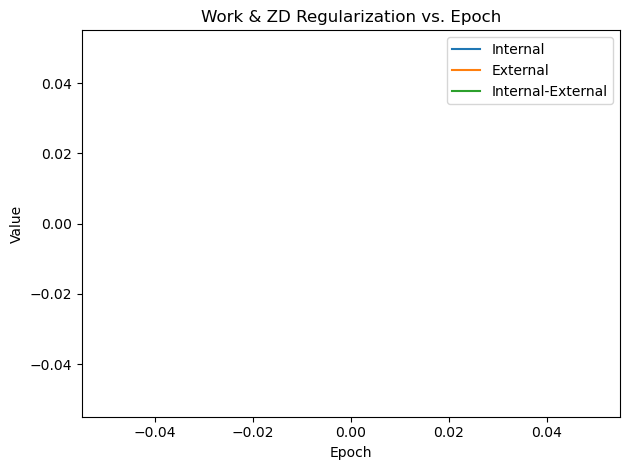

In [59]:
import matplotlib.pyplot as plt

# assume work_dict already exists, with lists of length N for each key
epochs = list(range(1, len(work_dict['Internal']) + 1))
# turn your lists into arrays
internal = np.array(work_dict['Internal'])
external = np.array(work_dict['External'])

# now subtraction works element‐wise
diff = internal - external
plt.figure()
plt.plot(epochs, work_dict['Internal'], label='Internal')
plt.plot(epochs, work_dict['External'], label='External')
plt.plot(epochs,diff, label='Internal-External')
#plt.plot(epochs, work_dict['ZD'], label='ZD')
#plt.plot(epochs, work_dict['Special'], label='Special')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Work & ZD Regularization vs. Epoch')

plt.legend()
plt.tight_layout()
plt.show()


## Export

In [133]:
model.eval()
time_idx=10

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)

In [134]:
for i in range(vf_number):
    tensor1 = VF_values[i,:,:].cpu()        # shape [1000,3]

    name='multi_VF_'+str(i)+'.txt'
    with open(name,'w') as f:
        for i, (x, y, z) in enumerate(tensor1.tolist(), start=1):
            f.write(f"{i},{x},{y},{z}\n")


# Parameter Recovery

In [61]:
model.eval()
time_idx=10

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)
#Vz=construct_VF(V_NN[20:30],delta_xyz)

#VF=torch.cat((Vx.unsqueeze(1),Vy.unsqueeze(1),Vz.unsqueeze(1)), dim=1)
grad_VF= construct_VF_gradients_batch(V_NN, delta_xyz)

#Strain
virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3)) #.detach().cpu().numpy()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (250x30 and 10x125)

In [250]:
# volumetric term:  ∑e  tr(Ereal)[e] * tr(Vvirt)[k,e] * vol_s[e]
A1 = torch.einsum('eii,kejj,e->ke',
                strain_tensor_3d[:,:,:,time_idx],    # <-- must be first, shape [125,3,3]
                virtual_strain,      # <-- second, shape [2,125,3,3]
                volume_tensor[:,0,time_idx])# <-- third, shape [125]
# A1.shape == [vf_number, Nelements] == [2,125]

# deviatoric (full inner‐product) term:
A2 = torch.einsum('eij,keij,e->ke',
                strain_tensor_3d[:,:,:,time_idx],    # [125,3,3]
                virtual_strain,      # [2,125,3,3]|
                volume_tensor[:,0,time_idx])# [125]


A = torch.stack([A1, A2], dim=1)       # → [2, n_vf, Ne]
M = A.mean(dim=2) 
M_mean=M /M.sum(dim=0, keepdim=True) 

In [251]:
M /M.sum(dim=0, keepdim=True) 

tensor([[-0.4013, -0.1617],
        [ 1.4013,  1.1617]], dtype=torch.float32, grad_fn=<DivBackward0>)

In [252]:
#Adding negative to the pressure becuase it is applied downwards...
t_surface=surface_normal_tensor[facet_idxs,:,s]*(-100000)*area_tensor[facet_idxs,:,s] #t_surface is N_pressure,3 (elements x xyz), add area because pressure is not force
#   print(f'W_int shape: {W_int.shape}')
dot = (VF_values[:,elem_idxs,:]* t_surface.unsqueeze(0)).sum(dim=2)  # shape: [3, 100]

W_ext=torch.sum(dot*area_tensor[facet_idxs,:,s].T,dim=(1))/(N_pressure_dofs*vf_number)

In [254]:
#Parameters
torch.matmul(W_ext,torch.inverse(M)).detach().cpu().numpy()

array([3887538.,  545551.], dtype=float32)

In [206]:
A_norm.mean(dim=2)

tensor([[-0.0849,  1.8176],
        [ 0.0108,  2.0849]], dtype=torch.float32, grad_fn=<MeanBackward1>)

In [207]:
# returns a namedtuple with .solution
res = torch.linalg.lstsq(M, W_ext)
x   = res.solution              # → shape (2,) or (2,1)
x_np = x.detach().cpu().numpy()
x_np

array([-91054.984, 108899.5  ], dtype=float32)

In [208]:
print_vf_equations(V_NN[0], fmt="{:+.3f}")

Vx(x,y,z) = +0.163*1 + -0.071*x + -0.032*y + +0.035*z + -0.332*x**2 + -0.386*x*y + +0.108*x*z + -0.125*y**2 + +0.085*y*z + -0.077*z**2
Vy(x,y,z) = +0.231*1 + -0.026*x + -0.036*y + -0.097*z + -0.120*x**2 + +0.000*x*y + +0.021*x*z + +0.029*y**2 + +0.037*y*z + -0.019*z**2
Vz(x,y,z) = -0.060*1 + -0.002*x + +0.057*y + -0.116*z + +0.006*x**2 + -0.040*x*y + -0.021*x*z + +0.111*y**2 + -0.044*y*z + +0.031*z**2


In [209]:
print_vf_equations(V_NN[1], fmt="{:+.3f}")

Vx(x,y,z) = +0.267*1 + +0.043*x + -0.150*y + -0.051*z + -0.275*x**2 + -0.238*x*y + +0.162*x*z + +0.014*y**2 + +0.073*y*z + -0.021*z**2
Vy(x,y,z) = +0.456*1 + -0.033*x + +0.073*y + -0.084*z + -0.056*x**2 + +0.019*x*y + +0.045*x*z + -0.004*y**2 + +0.060*y*z + +0.099*z**2
Vz(x,y,z) = -0.066*1 + -0.072*x + +0.010*y + -0.014*z + -0.019*x**2 + +0.011*x*y + -0.039*x*z + -0.080*y**2 + -0.117*y*z + +0.031*z**2


## When VFs are per element

In [62]:
model.eval()
time_idx=10

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values_per_element(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)
#Vz=construct_VF(V_NN[20:30],delta_xyz)

#VF=torch.cat((Vx.unsqueeze(1),Vy.unsqueeze(1),Vz.unsqueeze(1)), dim=1)
grad_VF= construct_vf_gradients_per_element(V_NN, delta_xyz)

#Strain
virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3)) #.detach().cpu().numpy()

In [63]:
VF_values.shape, virtual_strain.shape, virtual_strain.transpose(0,1).shape

(torch.Size([125, 2, 3]),
 torch.Size([125, 2, 3, 3]),
 torch.Size([2, 125, 3, 3]))

In [64]:

#Surface integral
#But what if we do it in all the cube... IDT we can because febio only gives normals from surfaces...


#Adding negative to the pressure becuase it is applied downwards...
t_surface=-surface_normal_tensor[facet_idxs,:,s]*(pressure_curve[s]) # shape: [25, 3] #*area_tensor[facet_idxs,:,s] #t_surface is N_pressure,3 (elements x xyz), add area because pressure is not force
#print(f't_surface shape: {t_surface.shape}')

dot = (VF_values[elem_idxs,:,:]* t_surface.unsqueeze(1)).sum(dim=2)  #shape: [25,2,3]@ [25,1,3] = shape: [25, 2]. Broadcast along 2nd dim (1st dim in t index)
#print(f'dot shape: {dot.shape}')

W_ext=dot*area_tensor[facet_idxs,:,time_idx]  #shape: [25,2]@ [25,1] = shape: [25, 2]
print(f'W_ext shape: {W_ext.shape}')


W_ext shape: torch.Size([25, 2])


In [65]:
VF_values[elem_idxs,:,:].shape, t_surface.shape, t_surface.unsqueeze(1).shape, (VF_values[elem_idxs,:,:]*t_surface.unsqueeze(1)).shape

(torch.Size([25, 2, 3]),
 torch.Size([25, 3]),
 torch.Size([25, 1, 3]),
 torch.Size([25, 2, 3]))

In [71]:
W_ext_all = torch.zeros(Nelements, 2, device=device, dtype=torch.float32) # assign
W_ext_all[elem_idxs,:] = W_ext

In [67]:
# volumetric term:  ∑e  tr(Ereal)[e] * tr(Vvirt)[k,e] * vol_s[e]
A1 = torch.einsum('eii,kejj,e->ke',
                strain_tensor_3d[:,:,:,time_idx],    # <-- must be first, shape [125,3,3]
                virtual_strain.transpose(0,1),      # <-- second, shape [2,125,3,3]
                volume_tensor[:,0,time_idx])# <-- third, shape [125]
# A1.shape == [vf_number, Nelements] == [2,125]

# deviatoric (full inner‐product) term:
A2 = torch.einsum('eij,keij,e->ke',
                strain_tensor_3d[:,:,:,time_idx],    # [125,3,3]
                virtual_strain.transpose(0,1),      # [2,125,3,3]|
                volume_tensor[:,0,time_idx])# [125]


A = torch.stack([A1[:,elem_idxs], A2[:,elem_idxs]], dim=1)       # → [2, n_vf, Ne]
M = A.mean(dim=2) 
M_mean=M /M.sum(dim=0, keepdim=True) 

In [68]:
A1.shape, A2.shape, A.shape, W_ext_all.shape, A.transpose(0,1).shape

(torch.Size([2, 125]),
 torch.Size([2, 125]),
 torch.Size([2, 2, 25]),
 torch.Size([125, 2]),
 torch.Size([2, 2, 25]))

In [69]:
params=torch.matmul(W_ext,torch.inverse(M)) #.detach().cpu().numpy()
params.mean(dim=0), params.shape

(tensor([-1.8410e+09, -7.9470e+08], dtype=torch.float32,
        grad_fn=<MeanBackward1>),
 torch.Size([25, 2]))

### Using all elements...

In [75]:
A = torch.stack([A1, A2], dim=1)       # → [2, n_vf, Ne]

# 1) Turn it into (125, 2, 2) by swapping dims
M_batched = A.permute(2, 0, 1)        # → (125, 2, 2)

# 2) Invert each 2×2 in one go
#   — you can use torch.inverse or torch.linalg.inv interchangeably here
M_inv_batched = torch.inverse(M_batched)  # works, double checked
# (or: M_inv_batched = torch.linalg.inv(M_batched))

# 3) Turn your W_ext into a column‐vector per batch
W_col   = W_ext_all.unsqueeze(1)      # → (125,1,2)

# 4) Batch‐matrix multiply: (1×2) @ (2×2) → (1×2), per batch
params  = torch.bmm(W_col, M_inv_batched)  # → (125,1,2)

# 5) Squeeze off the middle dim to get (125,2)
params  = params.squeeze(1)        # → (125,2)

# 6) If you only need NumPy:
params_np = params.detach().cpu().numpy()  

In [80]:
# Assemble M  (n_VF × n_param) for one element or block
#   M[k,m] = ∫_Ω   ε_v^(k) : ε_m   dV               (example isotropic case)
rank   = torch.linalg.matrix_rank(M_batched[0])
cond   = torch.linalg.cond(M_batched[0])

print(f"rank(M) = {rank}/{M.shape[1]},  cond(M) = {cond:.2e}")


rank(M) = 2/2,  cond(M) = 9.34e+00


In [81]:
torch.matmul(W_ext_all[0],M_inv_batched[0]) #.detach().cpu().numpy()

tensor([0., 0.], dtype=torch.float32, grad_fn=<SqueezeBackward4>)

In [82]:
M_inv_batched[0], W_ext_all[0]

(tensor([[-172094.5781, -163205.7812],
         [  78378.8672,   35196.0664]], dtype=torch.float32,
        grad_fn=<SelectBackward0>),
 tensor([0., 0.], dtype=torch.float32, grad_fn=<SelectBackward0>))

In [76]:
params_np

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.